### Audio t-SNE

This notebook will show you how to create a t-SNE plot of a group of audio clips. Along the way, we'll cover a few basic audio processing and machine learning tasks.

We will make two separate t-SNE plots. The first is clustering a group of many audio files in a single directory. The second one takes only a single audio track (a song) as it's input, segments it into many audio chunks (and saves them to a directory) and clusters the resulting chunks.

This notebook requires numpy, matplotlib, scikit-learn, and [librosa](https://github.com/librosa/librosa) to run. Refer to those libraries themselves for installation instructions.

After verifying you have the required libraries, verify the following import commands work.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import fnmatch
import os
import numpy as np
import librosa
from sklearn.manifold import TSNE
import json

First we need to scan some directory of audio files and collect all their paths into a single list. We can do that in the following code block (change path to be something in your system).

In [2]:
path = '/Users/gene/audio/Drum Samples'

files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.wav'):
        files.append(os.path.join(root, filename))

print("found %d .wav files in %s"%(len(files),path))


found 2121 .wav files in /Users/gene/audio/Drum Samples


In the next block, we're going to create a function which extracts a feature vector from an audio file. We are using [librosa](https://github.com/librosa/librosa/), a python library for audio analysis and music information retrieval, to handle the feature extraction.

The function we're creating `get_features` will take a waveform `y` at a sample rate `sr`, and extract features for only the first second of the audio. It is possible to use longer samples, but because we are interested in clustering according to sonic similarity, we choose to focus on short samples with relatively homogenous content over their durations. Longer samples have different sections and would require somewhat more sophisticated feature extraction.

The feature extraction will calculate the first 13 [mel-frequency cepstral coefficients](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) of the audio file, as well as their first- and second-order derivatives, and concatenate them into a single 39-element feature vector. The feature vector is also [standardized](https://en.wikipedia.org/wiki/Standard_score) so that each feature has equal variance.

In [3]:
def get_features(y, sr):
    y = y[0:sr]  # analyze just first second
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    log_S = librosa.logamplitude(S, ref_power=np.max)
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
    delta_mfcc = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    feature_vector = np.concatenate((np.mean(mfcc,1), np.mean(delta_mfcc,1), np.mean(delta2_mfcc,1)))
    feature_vector = (feature_vector-np.mean(feature_vector))/np.std(feature_vector)
    return feature_vector

Now we will iterate through all the files, and get their feature vectors, placing them into a new list `feature_vectors`.

In [4]:
feature_vectors = []
for i,f in enumerate(files):
    if i % 100==0:
        print "get %d of %d = %s"%(i+1, len(files), f)
    y, sr = librosa.load(f)
    feat = get_features(y, sr)
    feature_vectors.append(feat)

print("calculated %d feature vectors"%len(feature_vectors))

get 1 of 2121 = /Users/gene/audio/Drum Samples/AJK Percussion Synth/Bassdrum.wav
get 101 of 2121 = /Users/gene/audio/Drum Samples/Alesis HR-16/Claves.wav
get 201 of 2121 = /Users/gene/audio/Drum Samples/Boss DR-550/Bassdrums/Bassdrum-04.wav
get 301 of 2121 = /Users/gene/audio/Drum Samples/Emu SP12/BASSDRUM/Bassdrum-13.wav
get 401 of 2121 = /Users/gene/audio/Drum Samples/Korg M1/Cymbals/Hat Open-01.wav
get 501 of 2121 = /Users/gene/audio/Drum Samples/Linn 9000/BAssdrum.wav
get 601 of 2121 = /Users/gene/audio/Drum Samples/Rhythm-Ace/Hat Closed.wav
get 701 of 2121 = /Users/gene/audio/Drum Samples/Roland Digital Drum Brain DDR-30/Bassdrum-06.wav
get 801 of 2121 = /Users/gene/audio/Drum Samples/Roland MC-303/Bassdrums/Drybd1.wav
get 901 of 2121 = /Users/gene/audio/Drum Samples/Roland MC-303/Snaredrums/Funkysd1.wav
get 1001 of 2121 = /Users/gene/audio/Drum Samples/Roland R8/SNARES/Snaredrum-05.wav
get 1101 of 2121 = /Users/gene/audio/Drum Samples/Roland SH-09/Bassdrum-38.wav
get 1201 of 2121

Now we can run t-SNE over the feature vectors to get a 2-dimensional embedding of our audio files. We use scikit-learn's TSNE function, and additionally normalize the results so that they are between 0 and 1.

In [5]:
model = TSNE(n_components=2, learning_rate=150, perplexity=30, verbose=2, angle=0.1).fit_transform(feature_vectors)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2121
[t-SNE] Computed conditional probabilities for sample 2000 / 2121
[t-SNE] Computed conditional probabilities for sample 2121 / 2121
[t-SNE] Mean sigma: 0.170024
[t-SNE] Iteration 25: error = 2.4427838, gradient norm = 0.0003018
[t-SNE] Iteration 25: gradient norm 0.000302. Finished.
[t-SNE] Iteration 50: error = 2.2094839, gradient norm = 0.0116436
[t-SNE] Iteration 75: error = 2.0324588, gradient norm = 0.0076898
[t-SNE] Iteration 100: error = 1.9974920, gradient norm = 0.0072428
[t-SNE] Error after 100 iterations with early exaggeration: 1.997492
[t-SNE] Iteration 125: error = 1.7871766, gradient norm = 0.0048265
[t-SNE] Iteration 150: error = 1.7281264, gradient norm = 0.0043416
[t-SNE] Iteration 175: error = 1.7136724, gradient norm = 0.0042424
[t-SNE] Iteration 200: error = 1.7097583, gradient norm = 0.0042155
[t-SNE] Iteration 225: er

Let's plot our t-SNE points.  We can use matplotlib to quickly scatter them and see their distribution.

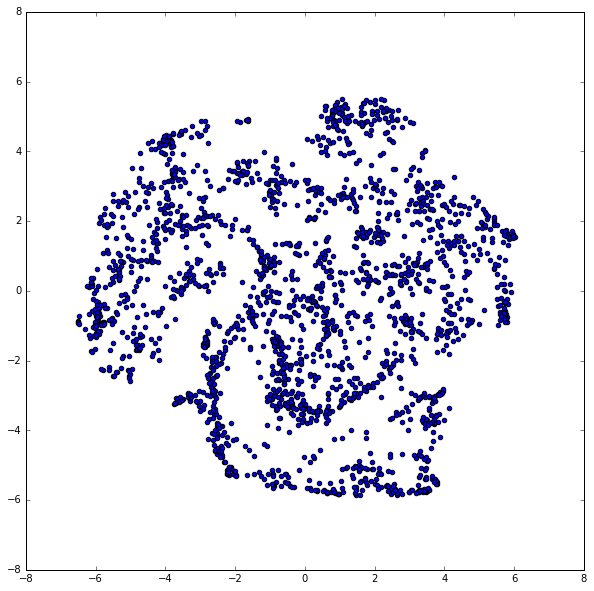

In [6]:
x_axis=model[:,0]
y_axis=model[:,1]

plt.figure(figsize = (10,10))
plt.scatter(x_axis, y_axis)
plt.show()

We see our t-SNE plot of our audio files, but it's not particularly interesting! Since we are dealing with audio files, there's no easy way to compare neighboring audio samples to each other. We can use some other, more interactive environment to view the results of the t-SNE. One way we can do this is by saving the results to a JSON file which stores the filepaths and t-SNE assignments of all the audio files. We can then load this JSON file in another environment. 

One example of this is provided in the "AudioTSNEViewer" application in [ml4a-ofx](https://github.com/ml4a/ml4a-ofx/tree/master/apps). This is an [openFrameworks](http://openframeworks.cc) application which loads all the audio clips into an interactive 2d grid (using the t-SNE layout) and lets you play each sample by hovering your mouse over it.  

In any case, to save the t-SNE to a JSON file, we first normalize the coordinates to between 0 and 1 and save them, along with the full filepaths.

In [7]:
x_norm = (x_axis - np.min(x_axis)) / (np.max(x_axis) - np.min(x_axis))
y_norm = (y_axis - np.min(y_axis)) / (np.max(y_axis) - np.min(y_axis))

data = []
for i in range(len(files)):
    data.append({"path":files[i], "x":x_norm[i], "y":y_norm[i]})
with open("points.json", 'w') as outfile:
    json.dump(data, outfile)

print("saved points.json to disk!")

saved points.json to disk!


Now what about if we want to do this same analysis, but instead of analyzing a directory of individual audio clips, we want to cut up a _single audio file_ into many chunks and cluster those instead. 

We can add a few extra lines of code to the above in order to do this. First let's select a piece of audio. Find any song on your computer that you want to do this analysis to and set a path to it.

In [8]:
source_audio = '/Users/gene/Downloads/bohemianrhapsody.mp3'

What we will now do is use librosa to calculate the _onsets_ of our audio file. Onsets are the timestamps to the beginning of discrete sonic events in our audio.

In [9]:
y, sr = librosa.load(source_audio)
onsets = librosa.onset.onset_detect(y=y, sr=sr, hop_length=512)
print(onsets)

[   20    38    47    55   110   181   198   214   223   231   248   328
   366   383   411   487   492   509   543   571   578   650   670   682
   689   707   784   799   801   818   840   847   857   938   957  1028
  1064  1082  1100  1120  1129  1139  1157  1192  1213  1249  1283  1295
  1303  1356  1370  1375  1392  1406  1411  1425  1462  1481  1496  1533
  1549  1569  1604  1620  1639  1676  1695  1714  1735  1786  1808  1824
  1843  1896  1951  2005  2022  2074  2117  2155  2173  2191  2210  2228
  2247  2265  2302  2320  2338  2357  2374  2394  2411  2425  2449  2485
  2521  2537  2540  2548  2556  2585  2631  2650  2667  2683  2703  2719
  2724  2729  2745  2762  2777  2796  2813  2825  2831  2842  2851  2863
  2877  2887  2901  2909  2922  2960  2977  2994  3007  3014  3068  3086
  3104  3123  3136  3142  3162  3178  3215  3234  3252  3270  3287  3326
  3353  3362  3388  3398  3434  3509  3546  3581  3620  3656  3674  3688
  3693  3729  3748  3766  3802  3821  3839  3857  3

How do we interpret these numbers?  Initially our original audio, at a sample rate `sr` is divided up into bins which each cointain 512 samples (specified by `hop_length` in the onset detection function). The onset numbers are an index to each of these bins. So for example, if the first onset is 20, this corresponds to sample 20 * 512 = 10,240. Given a sample rate of 22050, this corresponds to 10250/22050 = 0.46 seconds into the track.

Now what we will do is, we will go through each of the detected onsets, and crop the original audio to the interval from that onset until the next one. We will create a new folder, `../data/audio_clips`, into which we will then save all of the individual audio clips, and extract the same feature vector we described above for our new audio sample.

In [10]:
# where to save our new clips to
hop_length = 512  # make sure this matches what you used for the onset extraction
path_save_intervals = "../data/audio_clips"

# make new directory to save them 
if not os.path.isdir(path_save_intervals):
    os.mkdir(path_save_intervals)

# grab each interval, extract a feature vector, and save the new clip to our above path
feature_vectors = []
for i in range(len(onsets)-1):
    idx_y1 = onsets[i  ] * hop_length  # first sample of the interval
    idx_y2 = onsets[i+1] * hop_length  # last sample of the interval
    y_interval = y[idx_y1:idx_y2]
    features = get_features(y_interval, sr)   # get feature vector for the audio clip between y1 and y2
    file_path = '%s/onset_%d.wav' % (path_save_intervals, i)   # where to save our new audio clip
    feature_vectors.append({"file":file_path, "features":features})   # append to a feature vector
    librosa.output.write_wav(file_path, y_interval, sr)   # save to disk
    if i % 50 == 0:
        print "analyzed %d/%d = %s"%(i+1, len(onsets)-1, file_path)


analyzed 1/784 = ../data/audio_clips/onset_0.wav
analyzed 51/784 = ../data/audio_clips/onset_50.wav
analyzed 101/784 = ../data/audio_clips/onset_100.wav
analyzed 151/784 = ../data/audio_clips/onset_150.wav
analyzed 201/784 = ../data/audio_clips/onset_200.wav
analyzed 251/784 = ../data/audio_clips/onset_250.wav
analyzed 301/784 = ../data/audio_clips/onset_300.wav
analyzed 351/784 = ../data/audio_clips/onset_350.wav
analyzed 401/784 = ../data/audio_clips/onset_400.wav
analyzed 451/784 = ../data/audio_clips/onset_450.wav
analyzed 501/784 = ../data/audio_clips/onset_500.wav
analyzed 551/784 = ../data/audio_clips/onset_550.wav
analyzed 601/784 = ../data/audio_clips/onset_600.wav
analyzed 651/784 = ../data/audio_clips/onset_650.wav
analyzed 701/784 = ../data/audio_clips/onset_700.wav
analyzed 751/784 = ../data/audio_clips/onset_750.wav


In [11]:
# feature_vectors has both the features and file paths in it. let's pull out just the feature vectors
features_matrix = [f["features"] for f in feature_vectors]

# calculate a t-SNE and normalize it
model = TSNE(n_components=2, learning_rate=150, perplexity=30, verbose=2, angle=0.1).fit_transform(features_matrix)
x_axis=model[:,0] # normalize t-SNE
y_axis=model[:,1]
x_norm = (x_axis - np.min(x_axis)) / (np.max(x_axis) - np.min(x_axis))
y_norm = (y_axis - np.min(y_axis)) / (np.max(y_axis) - np.min(y_axis))

# save results to a json file
data = []
for i,f in enumerate(feature_vectors):
    data.append({"path":os.path.abspath(f["file"]), "x":x_norm[i], "y":y_norm[i]})
with open("points.json", 'w') as outfile:
    json.dump(data, outfile)

print("finished saving points.json")

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 784 / 784
[t-SNE] Mean sigma: 0.231958
[t-SNE] Iteration 25: error = 2.3657463, gradient norm = 0.0252830
[t-SNE] Iteration 50: error = 1.9268348, gradient norm = 0.0146605
[t-SNE] Iteration 75: error = 1.2931172, gradient norm = 0.0041796
[t-SNE] Iteration 100: error = 1.2243910, gradient norm = 0.0034621
[t-SNE] Error after 100 iterations with early exaggeration: 1.224391
[t-SNE] Iteration 125: error = 1.1278663, gradient norm = 0.0026092
[t-SNE] Iteration 150: error = 1.1007340, gradient norm = 0.0022601
[t-SNE] Iteration 175: error = 1.0944074, gradient norm = 0.0022007
[t-SNE] Iteration 200: error = 1.0926970, gradient norm = 0.0021857
[t-SNE] Iteration 225: error = 1.0922422, gradient norm = 0.0021815
[t-SNE] Iteration 250: error = 1.0921142, gradient norm = 0.0021804
[t-SNE] Iteration 275: error = 1.0920780, gradient norm = 0.0021801
[t-SNE] Ite

Let's plot the results on another scatter plot. One nice thing we can do is color the points according to their order in the original track. 

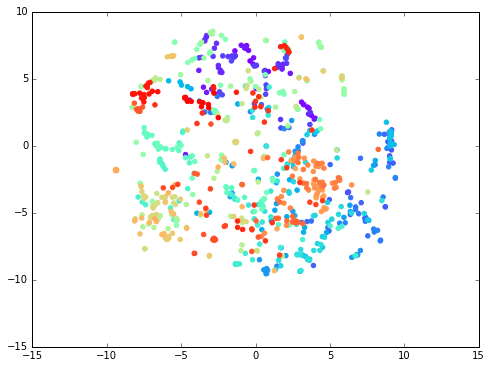

In [12]:
colors = cm.rainbow(np.linspace(0, 1, len(x_axis)))
plt.figure(figsize = (8,6))
plt.scatter(x_axis, y_axis, color=colors)
plt.show()

Not surprisingly, audio clips which appear close to each other (and therefore have a similar color) also cluster together in the t-SNE. Two clips that are right next to each other probably have similar sound content and therefore similar feature vectors. But we also see different sections (e.g. teal and orange) appearing clustered together as well. This suggests those two sections may have similar audio content as well.